---
# Imports

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, TimeSeriesSplit

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

---
# Load the data

In [4]:
df = pd.read_csv('../data/interpolated_without_nearest.csv')

C:\Users\Nikola\AppData\Local\Temp\ipykernel_17596\2052590027.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/interpolated_without_nearest.csv')


In [5]:
df.head(3)

,SensorId,Stamp,pm10,Hour,Month_Day_Calculation,pm10 - 1,pm10 - 2,pm10 - 3
0,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 00:45:00+00:00,68.0,0.75,1.032258,64.0,59.5,55.0
1,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:00:00+00:00,65.0,1.00,1.032258,68.0,64.0,59.5
2,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:15:00+00:00,54.0,1.25,1.032258,65.0,68.0,64.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216641 entries, 0 to 5216640
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SensorId               object 
 1   Stamp                  object 
 2   pm10                   float64
 3   Hour                   float64
 4   Month_Day_Calculation  float64
 5   pm10 - 1               float64
 6   pm10 - 2               float64
 7   pm10 - 3               float64
dtypes: float64(6), object(2)
memory usage: 318.4+ MB


---
# Data Preparation

## Sort for proper time series split

In [7]:
df = df.sort_values(by='Stamp')
df.reset_index(drop=True, inplace=True)

In [8]:
df

,SensorId,Stamp,pm10,Hour,Month_Day_Calculation,pm10 - 1,pm10 - 2,pm10 - 3
0,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 00:45:00+00:00,68.00,0.75,1.032258,64.0,59.50,55.0
1,8defa36a-62ca-448a-9ffb-5a2848c2dfa0,2023-01-01 00:45:00+00:00,122.00,0.75,1.032258,142.0,110.00,127.0
2,60aa65c6-b7c4-4aae-8769-5dbcba356b5d,2023-01-01 00:45:00+00:00,295.00,0.75,1.032258,281.0,381.00,259.0
3,6380c7cc-df23-4512-ad10-f2b363000579,2023-01-01 00:45:00+00:00,89.00,0.75,1.032258,90.0,79.00,117.0
4,1003,2023-01-01 00:45:00+00:00,81.75,0.75,1.032258,79.5,77.25,75.0
...,...,...,...,...,...,...,...,...
5216636,996a42d1-c6a3-4ec1-b879-bae2a55b7777,2024-11-21 23:00:00+00:00,19.00,23.00,11.700000,17.0,20.00,18.0
5216637,0f241923-b5b5-4c4a-bf08-279b9e3a8540,2024-11-21 23:00:00+00:00,41.00,23.00,11.700000,35.0,31.00,49.0
5216638,sensor_dev_84687_383,2024-11-21 23:00:00+00:00,18.00,23.00,11.700000,14.0,11.00,21.0
5216639,sensor_dev_78432_137,2024-11-21 23:00:00+00:00,33.00,23.00,11.700000,29.0,30.00,24.0


## Splitting the data

In [9]:
df.drop(columns=['SensorId', 'Stamp'], inplace=True)

In [10]:
X = df.drop(columns=['pm10'])
y = df['pm10']

---
# Testing

In [11]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

In [12]:
cv = TimeSeriesSplit(n_splits=5)

In [13]:
root_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_root_mean_squared_error')
r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')

print(f'Root mean squared error: {np.mean(-root_scores)} +/- {np.std(-root_scores)}')
print(f'R2: {np.mean(r2_scores)} +/- {np.std(r2_scores)}')

Root mean squared error: 14.618911683897727 +/- 3.7776881887815565
R2: 0.9823543467539053 +/- 0.007808075569609987


---
# Total Dataset Test

In [20]:
X_train, X_test = X.iloc[:int(0.8*len(X))], X.iloc[int(0.8*len(X)):]
y_train, y_test = y.iloc[:int(0.8*len(y))], y.iloc[int(0.8*len(y)):]

In [21]:
new_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])
new_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LinearRegression())])

In [22]:
print('R2:', r2_score(y_test, new_pipeline.predict(X_test)))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, new_pipeline.predict(X_test))))

R2: 0.984823798692776
Root mean squared error: 13.059254328022568


In [23]:
print(f'Baseline R2 Score: {r2_score(y_test, X_test["pm10 - 1"])}')
print(f'Baseline RMSE Score: {np.sqrt(mean_squared_error(y_test, X_test["pm10 - 1"]))}')

Baseline R2 Score: 0.982012205819207
Baseline RMSE Score: 14.217583753697408


In [28]:
old = 14.217583753697408
new = 13.059254328022568

im_f = (old - new) / old

In [31]:
print(f'Improvement: {np.round(im_f * 100, 2)}') 

Improvement: 8.15


---
# Long Term Prediction

In [19]:
new_df = pd.read_csv('../data/interpolated_without_nearest.csv')

new_df.dropna(inplace=True)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
new_df.head(3)

,SensorId,Stamp,pm10,Hour,Month_Day_Calculation,pm10 - 1,pm10 - 2,pm10 - 3
0,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 00:45:00+00:00,68.0,0.75,1.032258,64.0,59.5,55.0
1,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:00:00+00:00,65.0,1.00,1.032258,68.0,64.0,59.5
2,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:15:00+00:00,54.0,1.25,1.032258,65.0,68.0,64.0


In [ ]:
new_df = new_df[new_df['SensorId'] == '007f2b03-94e6-47b3-9e3e-44273354acd5']

In [ ]:
new_df['Stamp'] = pd.to_datetime(new_df['Stamp'], utc=True)

In [ ]:
new_df

,SensorId,Stamp,pm10,Hour,Month_Day_Calculation,pm10 - 1,pm10 - 2,pm10 - 3
0,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 00:45:00+00:00,68.0,0.75,1.032258,64.0,59.5,55.0
1,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:00:00+00:00,65.0,1.00,1.032258,68.0,64.0,59.5
2,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:15:00+00:00,54.0,1.25,1.032258,65.0,68.0,64.0
3,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:30:00+00:00,55.0,1.50,1.032258,54.0,65.0,68.0
4,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:45:00+00:00,56.0,1.75,1.032258,55.0,54.0,65.0
...,...,...,...,...,...,...,...,...
66324,007f2b03-94e6-47b3-9e3e-44273354acd5,2024-11-21 21:45:00+00:00,2.0,21.75,11.700000,1.0,3.0,4.0
66325,007f2b03-94e6-47b3-9e3e-44273354acd5,2024-11-21 22:00:00+00:00,5.0,22.00,11.700000,2.0,1.0,3.0
66326,007f2b03-94e6-47b3-9e3e-44273354acd5,2024-11-21 22:15:00+00:00,2.0,22.25,11.700000,5.0,2.0,1.0
66327,007f2b03-94e6-47b3-9e3e-44273354acd5,2024-11-21 22:30:00+00:00,3.0,22.50,11.700000,2.0,5.0,2.0


In [ ]:
new_df['Predicted'] = new_pipeline.predict(new_df.drop(columns=['SensorId', 'Stamp', 'pm10']))

In [ ]:
copy_new_df = new_df.copy()
MOVE = 55
copy_new_df = copy_new_df[-2000 + MOVE:-2000 + 96 + MOVE]

In [ ]:
first_3_pm10 = copy_new_df['pm10'].head(3).values.tolist()
first_3_stamps = copy_new_df['Stamp'].head(3).values

In [ ]:
first_3_stamps[0]

numpy.datetime64('2024-11-01T16:45:00.000000000')

In [ ]:
def get_next_pm10(stamp, pm10s):
    pm10_1 = pm10s[0]
    pm10_2 = pm10s[1]
    pm10_3 = pm10s[2]
    
    hour = int(str(stamp).split('T')[1].split(':')[0])
    minute = int(str(stamp).split('T')[1].split(':')[1])
    second = int(str(stamp).split('T')[1].split(':')[2].split('.')[0])
    
    hour_feature = hour + minute / 60 + second / 3600
    
    month = int(str(stamp).split('T')[0].split('-')[1])
    day = int(str(stamp).split('T')[0].split('-')[2])

    start_of_month = stamp.astype('datetime64[M]')
    start_of_next_month = start_of_month + np.timedelta64(1, 'M')

    days_in_month = (start_of_next_month - start_of_month).astype('timedelta64[D]').astype(int)

    
    month_feature = month + day / days_in_month
    
    return new_pipeline.predict(np.array([hour_feature, month_feature, pm10_1, pm10_2, pm10_3]).reshape(1, -1))

In [ ]:
results = [first_3_pm10[0], first_3_pm10[1], first_3_pm10[2]]
timestamps = [first_3_stamps[0], first_3_stamps[1], first_3_stamps[2], first_3_stamps[2] + np.timedelta64(15, 'm')]

for i in range(96 - 3):
    next_pm10 = get_next_pm10(timestamps[-1], results[-5:])
    results.append(next_pm10[0])
    timestamps.append(timestamps[-1] + np.timedelta64(15, 'm'))

c:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature nam

<Axes: xlabel='Stamp', ylabel='pm10'>

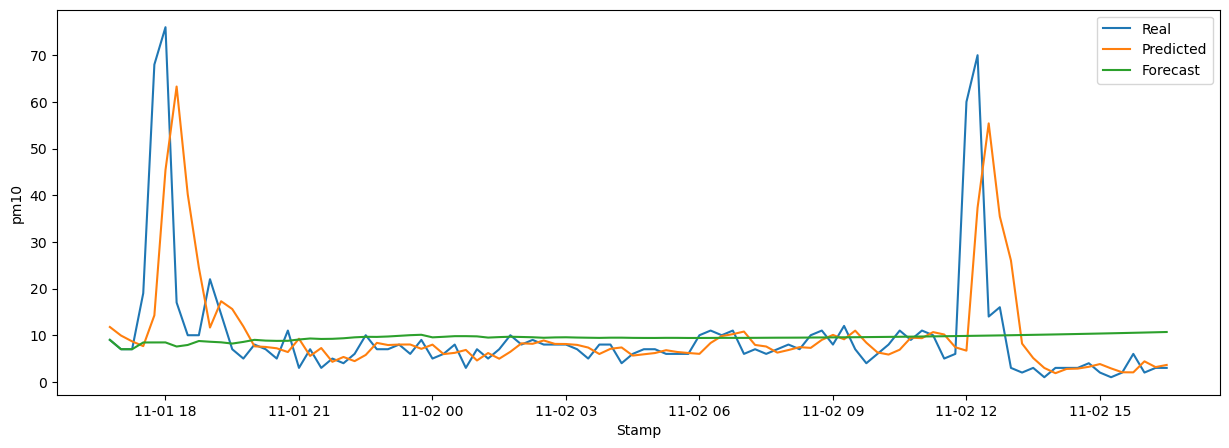

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

sns.lineplot(data=copy_new_df, x='Stamp', y='pm10', label='Real')
sns.lineplot(data=copy_new_df, x='Stamp', y='Predicted', label='Predicted')
sns.lineplot(x=timestamps[:-1], y=results, label='Forecast')

---